# Deep Q-Network (DQN): Discrete Lunar Lander problem
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.


### 1. Import the Necessary Packages

In [1]:
# render ai gym environment
#!pip install gymnasium[box2d]
import gymnasium as gym

#!pip install progressbar
import progressbar as pb

from collections import deque
import random
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
#%matplotlib inline

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
else:  
    #!python -m pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    display = Display(visible=True, size=(1400, 900))
    display.start()

# install package for displaying animation
#!pip install JSAnimation
from JSAnimation.IPython_display import display_animation

import torch
import torch.nn as nn
import torch.nn.functional as F

import DQN_agent as dqn_utils
from DQN_agent import Agent

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: ",device) 
plt.ion()

using device:  cuda:0


In [2]:
BUFFER_SIZE = int(5e5)  # replay buffer size int(1e5)
BATCH_SIZE = 128         # minibatch size 64
GAMMA = 0.99            # discount factor 0.99
TAU = 1e-3              # for soft update of target parameters 1e-3
LR = 2e-4               # learning rate  5e-4
UPDATE_EVERY = 4        # how often to update the network 4
OFF=0
MAIN=2
RIGHT=3
LEFT=1
ACTIONS=[0,2,3,1]
num2act = {num:act for num, act in zip(ACTIONS, ["OFF", "MAIN", "RIGHT", "LEFT"])}
LOWS=np.array([-1.5, -1.5, -5., -5., -3.1415927, -5., False, False])
HIGHS=np.array([1.5, 1.5, 5., 5., 3.1415927, 5., True, True])
norm = lambda x: (x - x.mean())/x.std() if x.std()!=0. else 0.
pix_norm = lambda x: x/255.
scale = lambda x: (x - x.min())/(x.max() - x.min()) if x.max()!=x.min() else x
SEED = 1234

def scale_input(state):
    st = np.zeros_like(state)
    st[:-2] = (state[:-2] - LOWS[:-2]) / (HIGHS[:-2] - LOWS[:-2])
    st[-2:] = state[-2:] 
    return st

def scale_input_batch(states):
    sts =  np.array([scale_input(state) for state in states])     
    return sts

def prep_input(state0, state1):
    '''Takes two sequential states and returns input to the network   
        Params
        states (np.array) shape (8,)
        Returns (np.array) shape (2,8) prepped for input 
    '''
    state0 = scale_input(state0)
    state1 = scale_input(state1)
    state = np.asarray([state0, state1])
    return state  



In [3]:
#print([k for k in gym.envs.registry.keys() if "Lunar" in k])  #.all().keys()  #.make
#gym.envs.registry['LunarLanderContinuous-v2']

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

The observation space is an 8-dimensional vector: 
* the coordinates of the lander (x & y), 
* its linear velocities (x & y), 
* its angle (radians), 
* its angular velocity, 
* and two booleans for whether/not each leg has ground contact.

Observation Highs:
* [1.5  1.5  5.0  5.0  3.14  5.0  True  True ]

Observation Lows:
* [-1.5  -1.5  -5.0  -5.0  -3.14  -5.0  False  False ]

Wind function:

tanh(sin(2 k (t+C)) + sin(pi k (t+C))). k is set to 0.01. C is sampled randomly between -9999 and 9999


### Observation Space

The observation space is an 8-dimensional vector: 
* the coordinates of the lander (x & y), 
* its linear velocities (x & y), 
* its angle (radians), 
* its angular velocity, 
* and two booleans for whether/not each leg has ground contact.

Observation Highs:
* [1.5  1.5  5.0  5.0  3.14  5.0  True  True ]

Observation Lows:
* [-1.5  -1.5  -5.0  -5.0  -3.14  -5.0  False  False ]

Wind function:

`tanh`(sin(2 k (t+C)) + sin(pi k (t+C))). k is set to 0.01. C is sampled randomly between -9999 and 9999


### Discrete Action Space

There are four discrete actions available:

* 0: do nothing
* 1: fire left orientation engine
* 2: fire main engine
* 3: fire right orientation engine


### Rewards

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

* is increased/decreased the closer/further the lander is to the landing pad.
* is increased/decreased the slower/faster the lander is moving.
* is decreased the more the lander is tilted (angle not horizontal).
* is increased by 10 points for each leg that is in contact with the ground.
* is decreased by 0.03 points each frame a side engine is firing.
* is decreased by 0.3 points each frame the main engine is firing.

The episode receives an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.

In [4]:
### 
OLD_GYM=False
if OLD_GYM:
    #env = gym.make("LunarLander-v2", render_mode="rgb_array")
    env = gym.make("LunarLander-v2", render_mode="rgb_array", options={'continuous': False,
                                                                       'gravity': -9.81,
                                                                       'enable_wind': True,
                                                                       'wind_power': 1.5,
                                                                       'turbulence_power': 0.15}
                  )
    #,
    #continuous = False, #False
    #gravity = -9.81, #0 and -12
    #enable_wind = True, #False
    #wind_power = 1.5, #0.0 and 20.0
    #turbulence_power = 0.15, #0.0 and 2.0
    #)

    state, info = env.reset(seed = 1234)
    obs = env.render()

    done = False
    while not done:
        action = env.action_space.sample()  # agent policy that uses the observation and info
        state, reward, done, trun, info = env.step(action)
        print(action, reward)
        obs = env.render()
        plt.imshow(obs)

    state_shape = env.observation_space.shape
    state_size = state_shape[0]
    action_size = env.action_space.n
    print('State shape: ', state_size)
    print('Number of actions: ', action_size)
    plt.imshow(obs)

State shape:  8
Number of actions:  4


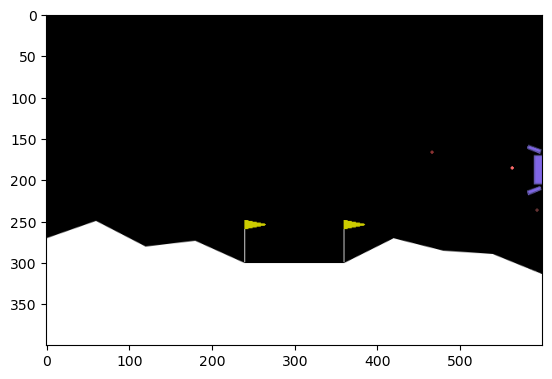

In [5]:
##### NEW GYM = GYMNASIUM
#!pip install gymnasium[box2d]
#import gymnasium as gym
env = gym.make("LunarLander-v2", render_mode="rgb_array",
                                 continuous= False,
                                 gravity= -9.81,
                                 enable_wind= True,
                                 wind_power= 0.88,
                                 turbulence_power= 0.08)
            #new_step_api=False,  )

state, info = env.reset(seed = 1234)
obs = env.render()
    
done = False
while not done:
    action = env.action_space.sample()  # agent policy that uses the observation and info
    state, reward, done, trun, info = env.step(action)
    #print(action, reward)
    obs = env.render()
    plt.imshow(obs)

state_shape = env.observation_space.shape
state_size = state_shape[0]
action_size = env.action_space.n
print('State shape: ', state_size)
print('Number of actions: ', action_size)
plt.imshow(obs)

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Evaluator(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=SEED):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Evaluator, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.state0 = nn.Linear(state_size, 2*state_size)
        self.state1 = nn.Linear(state_size, 2*state_size)
        self.hidden = nn.Linear(4*state_size, 4*action_size)
        self.out = nn.Linear(4*action_size, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values.
           Shape of input state should be: (batch_size, 2, state_size)
        """
        #print("input shape: ", state.shape)
        s0 = state[:,0,:]#.squeeze()
        s0 = F.relu(self.state0(s0))
        #print("s0 shape: ", s0.shape)
        s1 = state[:,1,:]#.squeeze()
        s1 = F.relu(self.state1(s1)) 
        #print("s1 shape: ", s1.shape)
        x = torch.cat((s0,s1), -1)
        #print("concat shape: ", x.shape)
        x = F.relu(self.hidden(x))
        return self.out(x)

evaluator = Evaluator(state_size, action_size)
evaluator = evaluator.to(device)
def evaluate(state, evaluator=evaluator):    
    """No_Grad a network to map state -> action values.
       Shape of input state should be: (batch_size, 2, state_size)
       Output shape should be: (batch_size, action_size)
    """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    evaluator.eval()
    with torch.no_grad():
        action_values = evaluator(state)
    evaluator.train()
    return action_values

In [8]:

agent = Agent(state_size, action_size, SEED)
#agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

In [ ]:
### Observe untrained agent

seed=SEED
t = 300
total_reward = 0.
smax = nn.Softmax(dim=-1).to(device)
pix_norm = lambda x: x/255.

state, _ = env.reset(seed=seed)
frame = env.render()
frame = pix_norm(frame)
img = plt.imshow(frame)
action =  np.random.choice(ACTIONS)   
for _ in range(t):
    state1, reward1, is_done, is_trunc, info = env.step(action)
    frame1 =  pix_norm(env.render())
    state2, reward2, is_done, is_trunc, info = env.step(0)
    frame2 =  pix_norm(env.render())
    state = np.asarray([scale_input(state1), 
                        scale_input(state2)])
    ### Evaluator
    pols = evaluate(state)
    probs = smax(pols).detach().cpu().numpy()
    #print("probs.shape", probs.shape)
    action = np.argmax(probs[-1]) #greedy choice of probs
    polaction = np.argmax(pols[-1].detach().cpu().numpy()) #greedy choice of pols
    #if action != polaction:
        #print("Action: {}  Polaction: {}".format(action, polaction))
        
    reward = round(reward1+reward2/2, 2)
    total_reward = round(reward+total_reward, 2)
    
    #frame = pix_norm(frame2)#      (frame1 + frame2)/2)
    frame = scale(frame2-frame1/2)
    img.set_data(frame)
    #pprobs = [p for p in np.round(probs[-1], 3)]
    #plt.title(str(pprobs)+"   "+ dqn_utils.num2act(action))
    plt.title(str(total_reward)+"   "+str(reward)+"   "+ dqn_utils.num2act[action])
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if is_done or is_trunc:
        break 

In [9]:
def two_step(state, eps):
    nul_state, reward1, done, trun, info = env.step(0)
    if done or trun:
        return nul_state, reward1, done or trun
    two_stateA = np.asarray([scale_input(nul_state), scale_input(state)])
    
    action = agent.act(two_stateA, eps)
    next_state, reward2, done, trun, info = env.step(action)
    
    two_stateB = np.asarray([scale_input(next_state), scale_input(nul_state)])
    agent.step(two_stateA, action, reward2, two_stateB, done or trun)
    return next_state, reward1+reward2, done or trun


def train_dqn(n_episodes=2000, max_steps=1000, 
              eps_start=1.0, eps_end=0.005, eps_decay=0.99):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    window_size = 100                  # scores to rolling-remember
    scores_window = deque(maxlen=window_size)
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        ### Begin new episode
        score = 0  
        state, _ = env.reset()
        for t in range(max_steps): 
            state, reward, done = two_step(state, eps)
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent episode score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  #\tEpsilon: {:.2f}
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(scores_window), eps))
        if np.mean(scores_window)>=121.0:
            print('\nEnvironment over-solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'highpoint.pth')
            break
        elif np.mean(scores_window)>=100.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')           
    return scores



In [10]:
n_episodes = 1000
max_t = 500
eps_start = 1.0
eps_end = 0.001
eps_decay = (eps_end/eps_start)**(1/n_episodes)

scores = train_dqn(n_episodes, max_t, eps_start, eps_end, eps_decay)

Episode 3	Average Score: -173.86

IndexError: too many indices for tensor of dimension 2

In [13]:
two_state = np.asarray([scale_input(state), scale_input(state)])
evaluate(two_state).squeeze()

tensor([-0.1331,  0.2205,  0.1934,  0.1535], device='cuda:0')

In [ ]:
# plot the scores
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, 'bo--', linewidth=0.25, markersize=1.0,)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
torch.save(agent.qnetwork_local.state_dict(), 'dqn_windypoint.pth')

In [ ]:
x = torch.randn(8, 2, 4)
print(x.shape, x)
#y = torch.randn(8, 2, 4)
x0 = x[:,0,:].squeeze()
x1 = x[:,1,:].squeeze()
print(x1.shape, x1)
#y = torch.reshape(x, (8,8))
y = torch.cat((x0,x1),1)
print(y.shape, y)

#print(y1)

In [ ]:
### Observe agent gameplay

t = 300
smax = nn.Softmax(dim=1)

state, _ = env.reset(seed=SEED)
frame = env.render()
img = plt.imshow(pix_norm(frame))
action =  np.random.choice(ACTIONS)   
for _ in range(t):
    state1, reward1, is_done, is_trunc, info = env.step(action)
    frame1 =  pix_norm(env.render())
    state2, reward2, is_done, is_trunc, info = env.step(OFF)
    frame2 =  pix_norm(env.render())
    states = np.asarray([scale_input(state1),
                         scale_input(state2)])
    probs = np.asarray([agent.act(s) for s in states])
    #pols = smax(sigs).detach().cpu().numpy()
    #probs = probs.detach().cpu().numpy()
    action = np.argmax(probs[-1])
    
    reward = reward2 + reward1/2
    
    frame = scale(frame2-frame1/2)
    img.set_data(frame)
    plt.title(str(action)+"    "+str(np.round(reward, 3)))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if is_done or is_trunc:
        break 

In [ ]:
states, agent.act(states)

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  